In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib. patches as mpatches
import math
import torch
import matplotlib.pyplot as plt
import scanpy as sc
import squidpy as sq
import anndata as ad
import pandas as pd
import anndata
from sklearn.cluster import KMeans
from scipy import io
from ariel_srt.Landmark import normalization_spatial, Rasterization, alternative_landmark, screen_landmark
from ariel_srt.Alignment import rigid_alignment, non_linear_align
from ariel_srt.Transfer import Appro_GP, Exact_GP

In [2]:
path = './data/hepatic lobular'

In [3]:
def process_data(adata, n_top_genes=2000):
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.match("^MT|^mt|^Mt")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
    sc.pp.filter_cells(adata, min_counts=500) 
    sc.pp.filter_genes(adata, min_cells=10)
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(
        adata, flavor="seurat", n_top_genes=n_top_genes, subset=True
    )
    return adata

In [4]:
matrix = io.mmread(f'{path}/15/matrix.mtx.gz').todense()
barcodes=np.array(pd.read_csv(f'{path}/15/barcodes.tsv',header=None, delimiter='\t'))
features=np.array(pd.read_csv(f'{path}/15/features.tsv',header=None, delimiter='\t'))
spatial=np.array(pd.read_csv(f'{path}/15/GSM5764425_tissue_positions_list_JBO015.csv',header=None))
note=np.array(pd.read_csv(f'{path}/15/annot_humanVisium.csv',header=0))

In [5]:
flattened_barcodes = barcodes.flatten()
indices = np.where(np.array([s.endswith('1_2') for s in flattened_barcodes]))[0]
matrix_2fat=matrix[:,indices]
barcodes = barcodes[indices]
note_fat2=note[note[:,3]=='JBO15',:]

group=[]
for i in barcodes:
    if (i in note_fat2[:,2]):
        group.append(note_fat2[note_fat2[:,2]==i,:][0,7])
    else:
        group.append('Unknown')
group=np.array(group).reshape((len(group),1))

barcodes_new = np.array([item[:-2] for item in barcodes[:,0]])

index=[]
for i in barcodes_new:
    index.append(np.where(spatial[:,0] == i)[0][0])

spatial_new=np.array(spatial[index,:][:,[4,5]]).astype(float)

barcodes_new=barcodes_new.reshape((barcodes_new.shape[0])).tolist()
features_new=features[:,0].reshape((features.shape[0])).tolist()
barcodes_new=pd.DataFrame(index=barcodes_new)
features_new=pd.DataFrame(index=features_new)

matrix_2fat=matrix_2fat.T

matrix_2fat=np.array(matrix_2fat)

fat2 = anndata.AnnData(X=matrix_2fat, obs=barcodes_new,var=features_new)
fat2.obsm['spatial']=spatial_new
fat2.obsm['zonationGroup']=np.array(group)

fat2 = process_data(fat2, n_top_genes=4000)

In [6]:
matrix = io.mmread(f'{path}/18/matrix.mtx.gz').todense()
barcodes=np.array(pd.read_csv(f'{path}/18/barcodes.tsv',header=None, delimiter='\t'))
features=np.array(pd.read_csv(f'{path}/18/features.tsv',header=None, delimiter='\t'))
spatial=np.array(pd.read_csv(f'{path}/18/GSM5764426_tissue_positions_list_JBO018.csv',header=None))
note=np.array(pd.read_csv(f'{path}/18/annot_humanVisium.csv',header=0))

In [7]:
flattened_barcodes = barcodes.flatten()
indices = np.where(np.array([s.endswith('1_3') for s in flattened_barcodes]))[0]
matrix_1health=matrix[:,indices]
barcodes = barcodes[indices]
note_health1=note[note[:,3]=='JBO18',:]

group=[]
for i in barcodes:
    if (i in note_health1[:,2]):
        group.append(note_health1[note_health1[:,2]==i,:][0,7])
    else:
        group.append('Unknown')
group=np.array(group).reshape((len(group),1))

barcodes_new = np.array([item[:-2] for item in barcodes[:,0]])

index=[]
for i in barcodes_new:
    index.append(np.where(spatial[:,0] == i)[0][0])

spatial_new=np.array(spatial[index,:][:,[4,5]]).astype(float)

barcodes_new=barcodes_new.reshape((barcodes_new.shape[0])).tolist()
features_new=features[:,0].reshape((features.shape[0])).tolist()
barcodes_new=pd.DataFrame(index=barcodes_new)
features_new=pd.DataFrame(index=features_new)

matrix_1health=matrix_1health.T
matrix_1health=np.array(matrix_1health)

health1 = anndata.AnnData(X=matrix_1health, obs=barcodes_new,var=features_new)
health1.obsm['spatial']=spatial_new
health1.obsm['zonationGroup']=np.array(group)

health1 = process_data(health1, n_top_genes=4000)

In [8]:
fat2_index=[]
health1_index=[]

for i in range(fat2.shape[1]):
    if(fat2.var_names[i] in health1.var_names):
        fat2_index.append(i)
        health1_index.append(np.where(health1.var_names==fat2.var_names[i])[0][0])

fat2=fat2[:,fat2_index]
health1=health1[:,health1_index]

In [9]:
print(fat2)
print(health1)

View of AnnData object with n_obs × n_vars = 530 × 1079
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial', 'zonationGroup'
    layers: 'counts'
View of AnnData object with n_obs × n_vars = 2497 × 1079
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n

(6088.05, 11696.95, 3714.6, 16043.4)

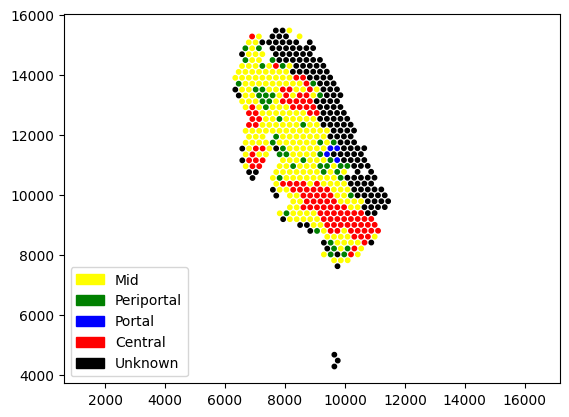

In [10]:
color_map = {'Mid': 'yellow', 'Central': 'red', 'Portal': 'blue','Periportal':'green','Unknown':'black'}
group=pd.DataFrame(fat2.obsm['zonationGroup'])
group.columns=['zonationGroup']
c = group['zonationGroup'].map(color_map)
plt.scatter(fat2.obsm['spatial'][:,0],fat2.obsm['spatial'][:,1],c=c,s=10)

patch1 = mpatches.Patch (color='yellow', label='Mid')
patch2 = mpatches.Patch (color='green', label='Periportal')   
patch3 = mpatches.Patch (color='blue', label='Portal')
patch4 = mpatches.Patch (color='red', label='Central') 
patch5 = mpatches.Patch (color='black', label='Unknown')
#add handles
handles, labels = plt. gca (). get_legend_handles_labels ()
handles. extend ([patch1, patch2, patch3, patch4, patch5])

#add legend
plt. legend (handles=handles,loc="lower left")

plt.axis('equal')

(3459.15, 16919.85, 3638.1, 17077.9)

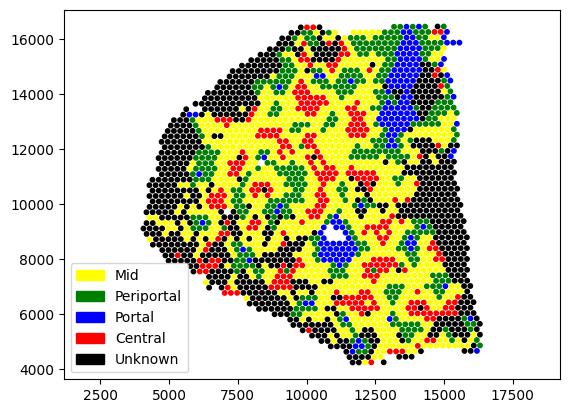

In [11]:
color_map = {'Mid': 'yellow', 'Central': 'red', 'Portal': 'blue','Periportal':'green','Unknown':'black'}
group=pd.DataFrame(health1.obsm['zonationGroup'])
group.columns=['zonationGroup']
c = group['zonationGroup'].map(color_map)
plt.scatter(health1.obsm['spatial'][:,0],health1.obsm['spatial'][:,1],c=c,s=10)

patch1 = mpatches.Patch (color='yellow', label='Mid')
patch2 = mpatches.Patch (color='green', label='Periportal')   
patch3 = mpatches.Patch (color='blue', label='Portal')
patch4 = mpatches.Patch (color='red', label='Central') 
patch5 = mpatches.Patch (color='black', label='Unknown')

handles, labels = plt. gca (). get_legend_handles_labels ()
handles. extend ([patch1, patch2, patch3, patch4, patch5])

plt. legend (handles=handles,loc="lower left")

plt.axis('equal')

In [12]:
FAT2=pd.DataFrame(fat2.layers['counts'])
HEALTH1=pd.DataFrame(health1.layers['counts'])

FAT2.index=fat2.obs_names
HEALTH1.index=health1.obs_names

FAT2.columns=fat2.var_names
HEALTH1.columns=health1.var_names

FAT2.to_csv(f'{path}/fat2.csv',header=True, index=True)
HEALTH1.to_csv(f'{path}/health1.csv',header=True, index=True)

pd.DataFrame(fat2.obsm['spatial']).to_csv(f'{path}/fat2_spatial.csv',header=False, index=False)
pd.DataFrame(health1.obsm['spatial']).to_csv(f'{path}/health1_spatial.csv',header=False, index=False)

fat2.write_h5ad(f'{path}/fat2.h5ad')
health1.write_h5ad(f'{path}/health1.h5ad')